In [1]:
## Import of all libraries needed
import pandas as pd
import numpy as np
import datetime
import gc
# graphics TP1
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2


In [2]:
## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
## Insert whatever audio file you want above

# Sampling
---

## objetivo

Escoger suficientes Device ID para que auctions contenga 100,000 registros.

## Hipotesis

El sample mantendrá la distribución de la muestra original.

## Pasos

1. Procesar con el TP1 los nuevos datos
2. Hacer un archivo con todos los device IDs de Auctions
3. Seleccionar al azar device IDs del archivo y buscar todos sus registros en auctions hasta que sean 100,000 registros
4. Procesar el sample como el TP1 para ver que la muestra sea valida. Es decir los graficos tienen que ser parecidos

### 1. Procesar con el TP1 los nuevos datos y observar los resultados para algunas de las preguntas

1. ¿Qué franja horaria contuvo la mayor cantidad de subastas?
3. ¿Qué franja horaria contuvo la mayor cantidad de events?
5. ¿En qué franja horaria se produjo la mayor cantidad de instalaciones?¶
11. ¿Cuáles fueron las distribuciones de los eventos de la muestra ?¿Y de los installs?
15. Eventos por aplicación.
17. ¿Existirá una relación entre los clientes y las aplicaciones ?

In [3]:
def fix_str_float(ds, col):
    ds[col] = ds[col].str.replace(r'[^0-9\.]','')
    ds[col] = np.where(ds[col]=='',np.nan,ds[col])
    ds[col] = ds[col].astype('float32')
    return ds[col].astype('float32')

In [4]:
# clicks
clicks_df = pd.read_csv('data/clicks.csv', low_memory=False,dtype={'advertiser_id':'int32','action_id':'float32','source_id':'int32','country_code':'category',\
                                                 'latitude':'float32','longitude':'float32','carrier_id':'float32','os_minor':'category',\
                                                  'os_major':'category','specs_brand':'category','timeToClick':'float32','ref_type':'category'\
                                                                  ,'ref_hash':'object'})

clicks_df['touchX'] = fix_str_float(clicks_df,'touchX')
clicks_df['touchY'] = fix_str_float(clicks_df,'touchY')
clicks_df['created'] = pd.to_datetime(clicks_df['created'])
#events
events_df = pd.read_csv('data/events.csv', low_memory=False, dtype={'event_id':'int32','ref_type':'category','application_id':'category',\
                                                                                            'attributed':'bool','device_countrycode':'category','device_city':'category',\
                                                                                            'trans_id':'category','carrier':'category','device_os':'category',\
                                                                                            'connection_type':'category'})
events_df['date'] = pd.to_datetime(events_df['date'])
events_df['wifi'].astype('bool', inplace=True)
events_df.drop(columns=['device_countrycode','session_user_agent','ip_address','device_language'], inplace=True)
# installs
installs_df = pd.read_csv('data/installs.csv', low_memory=False, dtype={'ref_type':'category','application_id':'category',\
                                                      'device_brand':'category','ref_hash':'object','wifi':'category'})
installs_df['kind'] = installs_df['kind'].str.lower()
installs_df['kind'] = installs_df['kind'].astype('category')
installs_df.drop(columns=['session_user_agent','ip_address','device_language','device_model'], inplace=True)
installs_df['created'] = pd.to_datetime(installs_df['created'])
installs_df.drop(['device_countrycode'], axis=1, inplace=True)
# auctions
auctions_df = pd.read_csv('data/auctions.csv', low_memory=False, dtype={'country':'category','platform':'category',\
                                                                        'ref_type_id':'category','source_id':'category','device_id':'object'})

auctions_df['date'] = pd.to_datetime(auctions_df['date'])
allDone()
print('setup done')


setup done


#### 1. ¿Qué franja horaria contuvo la mayor cantidad de subastas?

In [5]:
auctions_df.drop_duplicates(inplace=True)
auctions_df['hora'] = auctions_df['date'].apply(lambda x: ('%02d-%02d' % (x.hour, (x.hour+1))))
auctions_df['dia'] = auctions_df['date'].dt.day_name()+' '+auctions_df['date'].dt.day.map(str)
pivot_auctions = auctions_df.groupby(['dia','hora']).size().reset_index()
pivot_auctions.columns = ['dia','hora', 'count']
pivot_auctions = pivot_auctions.pivot_table(index='hora', columns='dia', values='count',aggfunc='sum', fill_value=0, dropna=False)
pivot_auctions = pivot_auctions[['Thursday 18', 'Friday 19', 'Saturday 20', 'Sunday 21', 'Monday 22', 'Tuesday 23', 'Wednesday 24', 'Thursday 25', 'Friday 26']]
allDone()
#display(pivot_auctions)



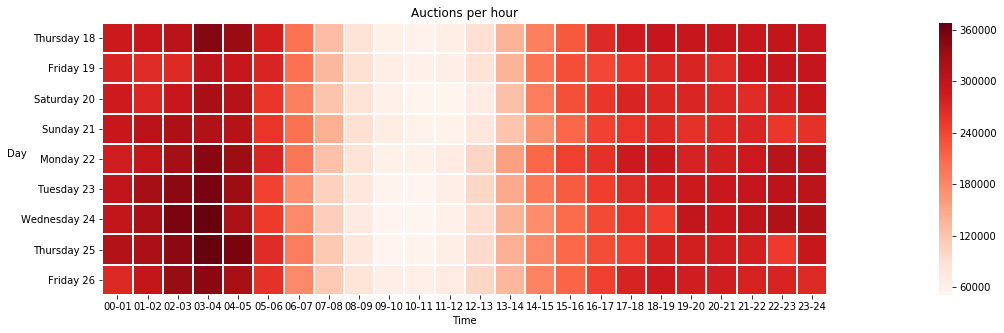

In [6]:
plt.figure(figsize = (40,5))
plt.title('Auctions per hour')
sns.heatmap(pivot_auctions.T, square = True, linewidth=1, cmap = 'Reds');
plt.xticks(rotation = 0);
plt.xlabel('Time');
plt.ylabel('Day', rotation=0);

In [7]:
pivot_auctions.max().max() #275362

367583

#### 3. ¿Qué franja horaria contuvo la mayor cantidad de events?

In [8]:
events_df['hora'] = events_df['date'].apply(lambda x: ('%02d-%02d' % (x.hour, (x.hour+1))))
events_df['dia'] = events_df['date'].dt.day_name()+' '+events_df['date'].dt.day.map(str)
pivot_events = events_df.groupby(['dia','hora']).size().reset_index()
pivot_events.columns = ['dia','hora', 'count']
pivot_events = pivot_events.pivot_table(index='hora', columns='dia', values='count',aggfunc='sum', fill_value=0, dropna=False)
pivot_events = pivot_events[['Thursday 18', 'Friday 19', 'Saturday 20', 'Sunday 21', 'Monday 22', 'Tuesday 23', 'Wednesday 24', 'Thursday 25', 'Friday 26']]


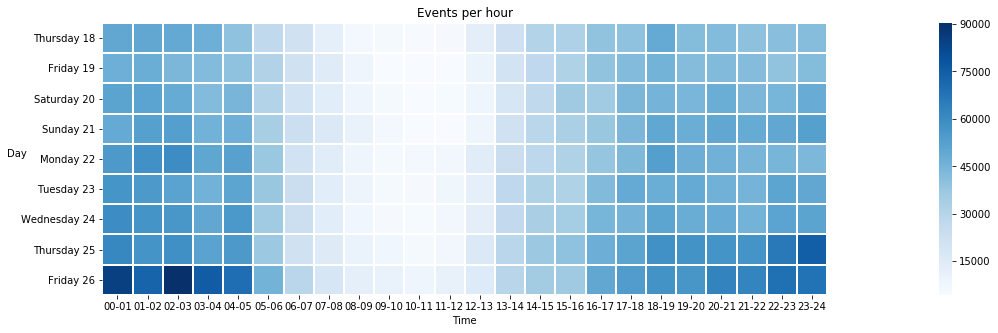

In [9]:
plt.figure(figsize = (40,5))
plt.title('Events per hour')
sns.heatmap(pivot_events.T, square = True, linewidth=1, cmap = 'Blues');
plt.xticks(rotation = 0);
plt.xlabel('Time');
plt.ylabel('Day', rotation=0);

#### 5. ¿En qué franja horaria se produjo la mayor cantidad de instalaciones?

In [10]:
installs_df['hora'] = installs_df['created'].apply(lambda x: ('%02d-%02d' % (x.hour, (x.hour+1))))
installs_df['dia'] = installs_df['created'].dt.day_name()+' '+installs_df['created'].dt.day.map(str)
pivot_installs = installs_df.groupby(['dia','hora']).size().reset_index()
pivot_installs.columns = ['dia','hora', 'count']
pivot_installs = pivot_installs.pivot_table(index='hora', columns='dia', values='count',aggfunc='sum', fill_value=0, dropna=False)
pivot_installs = pivot_installs[['Thursday 18', 'Friday 19', 'Saturday 20', 'Sunday 21', 'Monday 22', 'Tuesday 23', 'Wednesday 24', 'Thursday 25', 'Friday 26']]


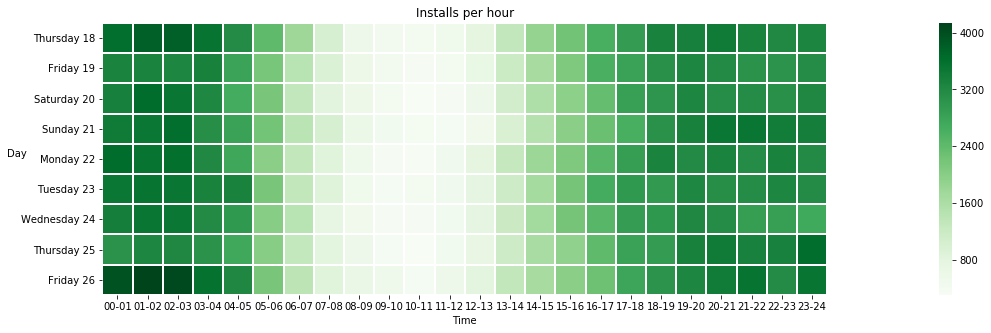

In [11]:
plt.figure(figsize = (40,5));
plt.title('Installs per hour');
sns.heatmap(pivot_installs.T, square = True, linewidth=1, cmap = 'Greens');
plt.xticks(rotation = 0);
plt.xlabel('Time');
plt.ylabel('Day', rotation=0);

#### 11. ¿Cuáles fueron las distribuciones de los eventos de la muestra ?¿Y de los installs?

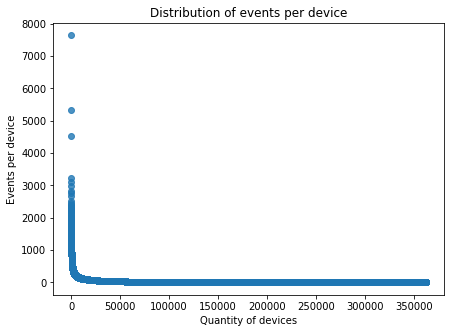

In [14]:
plt.figure(figsize = (7,5));
device_freq = events_df['ref_hash'].value_counts().to_frame().reset_index().reset_index()
device_freq.columns = ['x', 'ref_hash', 'count']

ax = sns.regplot(x=device_freq['x'], y=device_freq['count'], fit_reg=False);
ax.set_xlabel('Quantity of devices');
ax.set_ylabel('Events per device');
ax.set_title('Distribution of events per device');

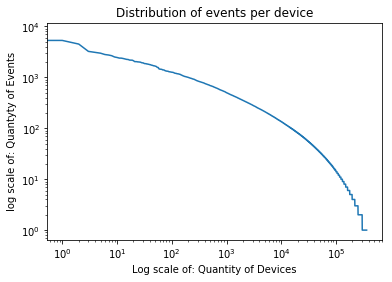

In [13]:
ax = device_freq.plot(x='x',y='count',loglog=True, legend=False);
ax.set_xlabel('Log scale of: Quantity of Devices');
ax.set_ylabel('log scale of: Quantyty of Events');
ax.set_title('Distribution of events per device');

### 2. Hacer un archivo con todos los device IDs de Auctions

Los IDs no pueden permanecer al target

In [ ]:
sample_percentage = 0.5/100; # 0.5% -> auctions, 50% -> convertions

In [ ]:
sample_percentage

#### IDs con auctions

In [ ]:
competencia_ids = pd.read_csv('data/target_competencia_ids.csv')
competencia_ids['ref_hash'] = competencia_ids['ref_hash'].str.replace('_sc', '')
competencia_ids['ref_hash'] = competencia_ids['ref_hash'].str.replace('_st', '')
competencia_ids.drop_duplicates(inplace=True)
pd.DataFrame(auctions_df.loc[~auctions_df['device_id'].isin(competencia_ids['ref_hash'])]['device_id'].unique(), columns=['device_id'], dtype='object').to_csv('data/auctions_ids.csv', index=False)



#### IDs con conversiones

In [ ]:
competencia_ids = pd.read_csv('data/target_competencia_ids.csv')
competencia_ids['ref_hash'] = competencia_ids['ref_hash'].str.replace('_sc', '')
competencia_ids['ref_hash'] = competencia_ids['ref_hash'].str.replace('_st', '')
competencia_ids.drop_duplicates(inplace=True)
convertions = installs_df[['ref_hash']].append(events_df[['ref_hash']], ignore_index=True)
pd.DataFrame(convertions.loc[~convertions['ref_hash'].isin(competencia_ids['ref_hash'])]['ref_hash'].unique(), columns=['ref_hash'], dtype='object').to_csv('data/convertions_ids.csv', index=False)



### 3. Seleccionar al azar device IDs del archivo y buscar todos sus registros en auctions hasta que sean 100,000 registros

Al menos 100,000 registros por ventana

#### Sample IDs

In [ ]:
auctions_ids = pd.read_csv('data/auctions_ids.csv', dtype={'device_id':'object'})
sample_size = auctions_ids.shape[0]

auctions_ids_sample = auctions_ids['device_id'].sample(n=int(sample_size*sample_percentage), random_state=3)
#save sample ids
auctions_ids_sample.to_frame().to_csv('data/auctions_ids_sample.csv', index=False)


In [ ]:
int(sample_size*sample_percentage)

In [ ]:
convertions_ids = pd.read_csv('data/convertions_ids.csv', dtype={'ref_hash':'object'})
sample_size = convertions_ids.shape[0]
convertions_ids_sample = convertions_ids['ref_hash'].sample(n=int(sample_size*sample_percentage), random_state=3)
#save sample ids
convertions_ids_sample.to_frame().to_csv('data/convertions_ids_sample.csv', index=False)

In [ ]:
int(sample_size*sample_percentage)

#### Auctions

In [ ]:
#auctions sample
auctions_sample = auctions_df.loc[auctions_df['device_id'].isin(auctions_ids_sample)].copy()
auctions_sample.to_csv('data/auctions_sample.csv', index=False)
display(auctions_df.shape)
auctions_sample.shape

In [ ]:
n = sum(1 for line in open('data/auctions_ids_sample.csv'))-1  # Calculate number of rows in file
n

#### Installs

In [ ]:
installs_sample = installs_df.loc[installs_df['ref_hash'].isin(auctions_ids_sample)].copy()
installs_sample.to_csv('data/installs_sample.csv', index=False)

#### Events

In [ ]:
events_sample = events_df.loc[events_df['ref_hash'].isin(auctions_ids_sample)].copy()
events_sample.to_csv('data/events_sample.csv', index=False)

### 4. Procesar el sample como el TP1 para ver que la muestra sea valida. Es decir los graficos tienen que ser parecidos

#### Auctions

In [ ]:
auctions_sample['hora'] = auctions_sample['date'].apply(lambda x: ('%02d-%02d' % (x.hour, (x.hour+1))))
auctions_sample['dia'] = auctions_sample['date'].dt.day_name()+' '+auctions_sample['date'].dt.day.map(str)
pivot_auctions = auctions_sample.groupby(['dia','hora']).size().reset_index()
pivot_auctions.columns = ['dia','hora', 'count']
pivot_auctions = pivot_auctions.pivot_table(index='hora', columns='dia', values='count',aggfunc='sum', fill_value=0, dropna=False)
pivot_auctions = pivot_auctions[['Thursday 18', 'Friday 19', 'Saturday 20', 'Sunday 21', 'Monday 22', 'Tuesday 23', 'Wednesday 24', 'Thursday 25', 'Friday 26']]
#display(pivot_auctions)



In [ ]:
max_auctions = pivot_auctions.max().max()

In [ ]:
min(np.inf, 10)

In [ ]:
plt.figure(figsize = (40,5))
plt.title('Sample Auctions per hour')
sns.heatmap(pivot_auctions.T/max_auctions, square = True, linewidth=1, cmap = 'Reds');
plt.xticks(rotation = 0);
plt.xlabel('Time');
plt.ylabel('Day', rotation=0);

In [ ]:
auctions_sample['hora'] = auctions_sample['date'].dt.hour
auctions_sample['dia'] = auctions_sample['date'].dt.day
pivot_auctions = auctions_sample.groupby(['dia','hora']).size().reset_index()
pivot_auctions.columns = ['dia','hora', 'count']
pivot_auctions['count'] = pivot_auctions['count']/max_auctions
pivot_auctions

In [ ]:
pivot_auctions.unstack().to_frame().reset_index()

#### Events

In [ ]:
events_sample['hora'] = events_sample['date'].apply(lambda x: ('%02d-%02d' % (x.hour, (x.hour+1))))
events_sample['dia'] = events_sample['date'].dt.day_name()+' '+events_sample['date'].dt.day.map(str)
pivot_events = events_sample.groupby(['dia','hora']).size().reset_index()
pivot_events.columns = ['dia','hora', 'count']
pivot_events = pivot_events.pivot_table(index='hora', columns='dia', values='count',aggfunc='sum', fill_value=0, dropna=False)
pivot_events = pivot_events[['Thursday 18', 'Friday 19', 'Saturday 20', 'Sunday 21', 'Monday 22', 'Tuesday 23', 'Wednesday 24', 'Thursday 25', 'Friday 26']]



In [ ]:
plt.figure(figsize = (40,5))
plt.title('Sample Events per hour')
sns.heatmap(pivot_events.T, square = True, linewidth=1, cmap = 'Blues');
plt.xticks(rotation = 0);
plt.xlabel('Time');
plt.ylabel('Day', rotation=0);

#### Installs

In [ ]:
installs_sample['hora'] = installs_sample['created'].apply(lambda x: ('%02d-%02d' % (x.hour, (x.hour+1))))
installs_sample['dia'] = installs_sample['created'].dt.day_name()+' '+installs_sample['created'].dt.day.map(str)
pivot_installs = installs_sample.groupby(['dia','hora']).size().reset_index()
pivot_installs.columns = ['dia','hora', 'count']
pivot_installs = pivot_installs.pivot_table(index='hora', columns='dia', values='count',aggfunc='sum', fill_value=0, dropna=False)
pivot_installs = pivot_installs[['Thursday 18', 'Friday 19', 'Saturday 20', 'Sunday 21', 'Monday 22', 'Tuesday 23', 'Wednesday 24', 'Thursday 25', 'Friday 26']]


In [ ]:
plt.figure(figsize = (40,5));
plt.title('Sample Installs per hour');
sns.heatmap(pivot_installs.T, square = True, linewidth=1, cmap = 'Greens');
plt.xticks(rotation = 0);
plt.xlabel('Time');
plt.ylabel('Day', rotation=0);

#### Distribución

In [ ]:
plt.figure(figsize = (7,5));
device_freq = events_sample['ref_hash'].value_counts().to_frame().reset_index().reset_index()
device_freq.columns = ['x', 'ref_hash', 'count']

ax = sns.regplot(x=device_freq['x'], y=device_freq['count'], fit_reg=False);
ax.set_xlabel('Quantity of devices');
ax.set_ylabel('Events per device');
ax.set_title('Sample distribution of events per device');

In [ ]:
ax = device_freq.plot(x='x',y='count',loglog=True, legend=False);
ax.set_xlabel('Log scale of: Quantity of Devices');
ax.set_ylabel('log scale of: Quantyty of Events');
ax.set_title('Distribution of events per device');

In [ ]:
allDone()

# Process Dataset for Auctions

In [4]:
def fit_and_score_features(X, y, alpha=0.1):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis(alpha=alpha)
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores


In [5]:
def remove_unused_cols(X):
    #remove empty columns
    to_drop = []
    for col in X.select_dtypes(include='number').columns:
        if X[col].sum()==0:
            to_drop.append(col)
    if len(to_drop)>0:
        X = X.drop(columns=to_drop)
    return X

In [6]:
class preprocess( BaseEstimator, TransformerMixin ): 
    #Return self nothing else to do here
    def fit( self, X, y = None  ):
        return self
    #Transformer method we wrote for this transformer 
    def transform(self, X , y = None ):
        # X = X.copy() # do we need this line
        # boolean transformations
        if 'event_uuid' in X.columns:
            X['event_uuid'] = np.where(X['event_uuid'].isnull(), 0,1)
        if 'click_hash' in X.columns:
            X['click_hash'] = np.where(X['click_hash'].isnull(), 0,1)
        if 'Android' in X.columns:
            X['Android'] = np.where(X['user_agent'].str.contains('Android', regex=False),1,0)
        if 'iOS' in X.columns:
            X['iOS'] = np.where(X['user_agent'].str.contains('Darwin', regex=False) | X['user_agent'].str.contains('iOS', regex=False),1,0)
        if 'trans_id' in X.columns:
            X['trans_id'] = np.where(X['trans_id'].isnull(), 0,1)
        # date transformations
        if 'created' in X.columns:
            X['created_weekday'] = X['created'].dt.weekday
            X['created_hour'] = X['created'].dt.hour
            X['created_minute'] = X['created'].dt.minute
        if 'date' in X.columns:
            X['date_weekday'] = X['date'].dt.weekday
            X['date_hour'] = X['date'].dt.hour
            X['date_minute'] = X['date'].dt.minute
            X['date_second'] = X['date'].dt.second
        #remove unused columns
        to_drop = []
        for col in ['date','created', 'install_diff','device_brand','install_seconds','user_agent','device_id']:
            if col in X.columns:
                to_drop.append(col)
        X = X.drop(columns=to_drop)
        X = pd.get_dummies(X, dummy_na=True, prefix_sep='=')
        #returns numpy array
        return X

    

In [7]:
def custom_cv_folds(X):
    myCViterator = []
    trainIndices = X.loc[X['date']<'2019-04-21 00:00:00'].index.values.astype(int)
    testIndices =  X.loc[('2019-04-21 00:00:00'<=X['date']) & (X['date']<'2019-04-24 00:00:00')].index.values.astype(int)
    myCViterator.append( (trainIndices, testIndices) )
    trainIndices = X.loc[('2019-04-19 00:00:00'<=X['date']) & (X['date']<'2019-04-22 00:00:00')].index.values.astype(int)
    testIndices =  X.loc[('2019-04-22 00:00:00'<=X['date']) & (X['date']<'2019-04-25 00:00:00')].index.values.astype(int)
    myCViterator.append( (trainIndices, testIndices) )
    trainIndices = X.loc[('2019-04-20 00:00:00'<=X['date']) & (X['date']<'2019-04-23 00:00:00')].index.values.astype(int)
    testIndices =  X.loc[('2019-04-23 00:00:00'<=X['date']) & (X['date']<'2019-04-26 00:00:00')].index.values.astype(int)
    myCViterator.append( (trainIndices, testIndices) )
    trainIndices = X.loc[('2019-04-21 00:00:00'<=X['date']) & (X['date']<'2019-04-24 00:00:00')].index.values.astype(int)
    testIndices =  X.loc[('2019-04-24 00:00:00'<=X['date']) & (X['date']<'2019-04-27 00:00:00')].index.values.astype(int)
    myCViterator.append( (trainIndices, testIndices) )
    return myCViterator


In [8]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

In [9]:
#read from sample
auctions_ids_sample = pd.read_csv('data/auctions_ids_sample.csv', dtype={'device_id':'object'})['device_id']

In [10]:
# auctions
auctions_df = pd.read_csv('data/auctions.csv', low_memory=False, dtype={'country':'category','platform':'category',\
                                                                        'ref_type_id':'category','source_id':'category','device_id':'object'})
auctions_df['date'] = pd.to_datetime(auctions_df['date'])
auctions_sample = auctions_df.loc[auctions_df['device_id'].isin(auctions_ids_sample)].copy()
# installs
installs_df = pd.read_csv('data/installs.csv', low_memory=False, dtype={'ref_type':'category','application_id':'category',\
                                                      'device_brand':'category','ref_hash':'object','wifi':'category'})
installs_df['kind'] = installs_df['kind'].str.lower()
installs_df['kind'] = installs_df['kind'].astype('category')
installs_df.drop(columns=['session_user_agent','ip_address','device_language','device_model'], inplace=True)
installs_df['created'] = pd.to_datetime(installs_df['created'])
installs_df.drop(['device_countrycode'], axis=1, inplace=True)
installs_sample = installs_df.loc[installs_df['ref_hash'].isin(auctions_ids_sample)].copy()
#installs_sample.to_csv('data/installs_sample.csv', index=False)
#events
events_df = pd.read_csv('data/events.csv', low_memory=False, dtype={'event_id':'int32','ref_type':'category','application_id':'category',\
                                                                                            'attributed':'bool','device_countrycode':'category','device_city':'category',\
                                                                                            'trans_id':'category','carrier':'category','device_os':'category',\
                                                                                            'connection_type':'category'})
events_df['date'] = pd.to_datetime(events_df['date'])
events_df['wifi'].astype('bool', inplace=True)
events_df.drop(columns=['device_countrycode','session_user_agent','ip_address','device_language'], inplace=True)
events_sample = events_df.loc[events_df['ref_hash'].isin(auctions_ids_sample)].copy()
#events_sample.to_csv('data/events_sample.csv', index=False) 
del events_df
del auctions_df
del installs_df
gc.collect()
allDone()
print('setup done')

setup done


In [12]:
auctions_sample.shape

(241085, 4)

In [221]:
# calculate time in seconds
auctions_sample.drop_duplicates(inplace=True)
auctions_sample = auctions_sample.sort_values(by=['device_id','date'])
auctions_sample['date_dif'] = auctions_sample['date'].shift(periods=-1) - auctions_sample['date']
auctions_sample['device_id_next'] = auctions_sample['device_id'].astype('object').shift(periods=-1)
auctions_sample['date_dif'] = pd.to_timedelta(np.where(auctions_sample['device_id_next']==auctions_sample['device_id'], auctions_sample['date_dif'], np.where(auctions_sample['date']+pd.DateOffset(3)>'2019-04-27 00:00:00', datetime.datetime(2019,4,27)-auctions_sample['date'], pd.to_timedelta(3, unit='d'))))
auctions_sample['in_seconds'] = auctions_sample['date_dif'].dt.total_seconds()
auctions_sample['status_censored'] = ((auctions_sample['device_id_next']==auctions_sample['device_id']) & (auctions_sample['in_seconds']<259200.0))
auctions_sample.drop(['device_id_next','date_dif'], axis='columns', inplace=True)
auctions_sample['device_id'] = auctions_sample['device_id'].astype('object')
#calculate previous time in seconds
auctions_sample['date_prev'] = auctions_sample['date'].shift()
auctions_sample['date_dif_prev'] = auctions_sample['date']- auctions_sample['date_prev']
auctions_sample['device_id_prev'] = auctions_sample['device_id'].astype('object').shift()
auctions_sample['date_dif_prev'] = pd.to_timedelta(np.where(auctions_sample['device_id_prev']==auctions_sample['device_id'], auctions_sample['date_dif_prev'], np.where(auctions_sample['date']-pd.DateOffset(3)<'2019-04-18 00:00:00', auctions_sample['date']-datetime.datetime(2019,4,18), pd.to_timedelta(3, unit='d'))))
auctions_sample['last_seen'] = auctions_sample['date_dif_prev'].dt.total_seconds()
auctions_sample.drop(['device_id_prev','date_dif_prev','date_prev'], axis='columns', inplace=True)
auctions_sample = auctions_sample.sort_values(by=['date'])



In [222]:
auct_cols = auctions_sample.columns.tolist()

In [224]:
#some features
auct_cols = auctions_sample.columns.tolist()
print(1)
#installs and evetns
events_sample['kind'] = 'event'
print(2)
installs_sample['kind'] = installs_sample['kind'].str.replace(' ', '_').str.lower()
print(3)
#information about last installs and events
applications = installs_sample[['ref_hash','created','application_id','kind']].append(events_sample[['ref_hash', 'date', 'application_id','kind']].rename(columns = {'date':'created'}), ignore_index=True)
print(4)
data_1 = pd.merge(auctions_sample, applications, left_on='device_id', right_on='ref_hash', how='left')
print(5)
#only previus installs or events
data_1 = data_1.loc[(data_1['date']>data_1['created']) | data_1['created'].isnull()]
print(6)

# application_id feature by id
app_id_1 = data_1[['application_id','kind']].copy()
print(7)
app_id_1 = pd.get_dummies(app_id_1, dummy_na=True, prefix_sep='=')
print(8)
data_1.drop(columns=['application_id'], inplace=True)
print(9)
data_1 = pd.merge(data_1, app_id_1, left_index=True, right_index=True, how='inner')
print(10)

app_id_1_columns = app_id_1.columns.tolist()
print(11)

group_1 = data_1.groupby(auct_cols).agg({col:'sum' for col in app_id_1_columns})
print(12)
group_1.reset_index(inplace=True)

del installs_sample
del events_sample
gc.collect()
print(13)
auctions_sample = pd.merge(auctions_sample, group_1, on=['date','device_id','ref_type_id','source_id','in_seconds','status_censored', 'last_seen'], how='left')
print(14)
auctions_sample = auctions_sample.astype({col:'float32' for col in app_id_1_columns})
print(15)

auctions_sample['hora'] = auctions_sample['date'].dt.hour
auctions_sample['dia'] = auctions_sample['date'].dt.day
pivot_auctions = auctions_sample.groupby(['dia','hora']).size().reset_index()
pivot_auctions.columns = ['dia','hora', 'hour_day_dist']
max_auctions = pivot_auctions['hour_day_dist'].max().max()
pivot_auctions['hour_day_dist'] = pivot_auctions['hour_day_dist']/max_auctions
display(pivot_auctions.head(5))
print(auctions_sample.shape)
auctions_sample = pd.merge(auctions_sample, pivot_auctions, on=['dia','hora'], how='left')
auctions_sample.drop(columns=['hora','dia'], inplace=True)
print(auctions_sample.shape)

auctions_sample.fillna(value={'application_id=nan':1,'kind=nan':1}, inplace=True)
print(16)
auctions_sample.fillna(value={col:0 for col in app_id_1_columns}, inplace=True)
print(17)
auctions_sample = auctions_sample.astype({col:'int32' for col in app_id_1_columns})
print(18)
auctions_sample.reset_index(inplace=True, drop=True)
print(19)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


,dia,hora,hour_day_dist
0,18,0,0.720353
1,18,1,0.625736
2,18,2,0.664424
3,18,3,0.651388
4,18,4,0.660219


(241085, 128)
(241085, 127)
16
17
18
19


In [225]:
auctions_sample.memory_usage(index=True).sum()

125123691

In [226]:
new_dtypes = {col: ('datetime64' if col=='date' else ('object' if col=='device_id' else ('category' if col=='ref_type_id' or col=='source_id' else ('float64' if col=='in_seconds' or col=='last_seen' or col=='hour_day_dist' else ('bool' if col=='status_censored' else 'int16'))))) for col in auctions_sample.columns}
auctions_sample = auctions_sample.astype(new_dtypes, copy=False)
features = np.setdiff1d(auctions_sample.columns, ['in_seconds', 'status_censored'] ).tolist()
corr = auctions_sample[features].corr()
#remove uncorrelated columns (less than: -0.95)
corr = pd.DataFrame(np.tril(corr), columns=corr.columns, index=corr.index) #triangular inferior
removed_corr = corr.loc[(corr<-0.95).any()].index.tolist()
print(removed_corr)
corr_columns = np.setdiff1d(auctions_sample.columns, removed_corr ).tolist()
if not('date' in corr_columns):
    corr_columns.append('date')
if not('device_id' in corr_columns):
    corr_columns.append('device_id')
if not('ref_type_id' in corr_columns):
    corr_columns.append('ref_type_id')
if not('source_id' in corr_columns):
    corr_columns.append('source_id')
if not('in_seconds' in corr_columns):
    corr_columns.append('in_seconds')
if not('last_seen' in corr_columns):
    corr_columns.append('last_seen')
if not('status_censored' in corr_columns):
    corr_columns.append('status_censored')
if not('hour_day_dist' in corr_columns):
    corr_columns.append('hour_day_dist')

auctions_sample = auctions_sample[corr_columns]
new_dtypes = {col: ('datetime64' if col=='date' else ('object' if col=='device_id' else ('category' if col=='ref_type_id' or col=='source_id' else ('float64' if col=='in_seconds' or col=='last_seen' or col=='hour_day_dist' else ('bool' if col=='status_censored' else 'int16'))))) for col in auctions_sample.columns}
auctions_sample.to_csv('data/auctions_sample_merged_05.csv', index=False) 



[]


In [227]:
allDone()
new_dtypes

{'application_id=101': 'int16',
 'application_id=116': 'int16',
 'application_id=117': 'int16',
 'application_id=121': 'int16',
 'application_id=122': 'int16',
 'application_id=123': 'int16',
 'application_id=126': 'int16',
 'application_id=128': 'int16',
 'application_id=129': 'int16',
 'application_id=13': 'int16',
 'application_id=133': 'int16',
 'application_id=135': 'int16',
 'application_id=14': 'int16',
 'application_id=140': 'int16',
 'application_id=143': 'int16',
 'application_id=145': 'int16',
 'application_id=147': 'int16',
 'application_id=153': 'int16',
 'application_id=155': 'int16',
 'application_id=158': 'int16',
 'application_id=159': 'int16',
 'application_id=161': 'int16',
 'application_id=163': 'int16',
 'application_id=165': 'int16',
 'application_id=167': 'int16',
 'application_id=170': 'int16',
 'application_id=175': 'int16',
 'application_id=180': 'int16',
 'application_id=185': 'int16',
 'application_id=187': 'int16',
 'application_id=188': 'int16',
 'applicat

In [ ]:
auctions_sample.shape

# Process for Convertions

In [5]:
def preprocess(self, X , y = None ):
    # X = X.copy() # do we need this line
    # boolean transformations
    if 'event_uuid' in X.columns:
        X['event_uuid'] = np.where(X['event_uuid'].isnull(), 0,1)
    if 'click_hash' in X.columns:
        X['click_hash'] = np.where(X['click_hash'].isnull(), 0,1)
    if 'Android' in X.columns:
        X['Android'] = np.where(X['user_agent'].str.contains('Android', regex=False),1,0)
    if 'iOS' in X.columns:
        X['iOS'] = np.where(X['user_agent'].str.contains('Darwin', regex=False) | X['user_agent'].str.contains('iOS', regex=False),1,0)
    if 'trans_id' in X.columns:
        X['trans_id'] = np.where(X['trans_id'].isnull(), 0,1)
    # date transformations
    if 'created' in X.columns:
        X['created_weekday'] = X['created'].dt.weekday
        X['created_hour'] = X['created'].dt.hour
        X['created_minute'] = X['created'].dt.minute
    if 'date' in X.columns:
        X['date_weekday'] = X['date'].dt.weekday
        X['date_hour'] = X['date'].dt.hour
        X['date_minute'] = X['date'].dt.minute
        X['date_second'] = X['date'].dt.second
    #remove unused columns
    to_drop = []
    for col in ['date','created', 'install_diff','device_brand','install_seconds','user_agent','device_id']:
        if col in X.columns:
            to_drop.append(col)
    X = X.drop(columns=to_drop)
    X = pd.get_dummies(X, dummy_na=True, prefix_sep='=')
    #returns numpy array
    return X

    

In [6]:
#read from sample
convertions_ids_sample = pd.read_csv('data/convertions_ids_sample.csv', dtype={'ref_hash':'object'})['ref_hash']

In [7]:
# auctions
#auctions_df = pd.read_csv('data/auctions.csv', low_memory=False, dtype={'country':'category','platform':'category',\
#                                                                        'ref_type_id':'category','source_id':'category','device_id':'object'})
#auctions_df['date'] = pd.to_datetime(auctions_df['date'])
#auctions_sample = auctions_df.loc[auctions_df['device_id'].isin(auctions_ids_sample)].copy()
# installs
installs_df = pd.read_csv('data/installs.csv', low_memory=False, dtype={'ref_type':'category','application_id':'category',\
                                                      'device_brand':'category','ref_hash':'object','wifi':'category'})
installs_df['kind'] = installs_df['kind'].str.lower()
installs_df['kind'] = installs_df['kind'].astype('category')
installs_df.drop(columns=['session_user_agent','ip_address','device_language','device_model'], inplace=True)
installs_df['created'] = pd.to_datetime(installs_df['created'])
installs_df.drop(['device_countrycode'], axis=1, inplace=True)
installs_sample = installs_df.loc[installs_df['ref_hash'].isin(convertions_ids_sample)].copy()
#events
events_df = pd.read_csv('data/events.csv', low_memory=False, dtype={'event_id':'int32','ref_type':'category','application_id':'category',\
                                                                                            'attributed':'bool','device_countrycode':'category','device_city':'category',\
                                                                                            'trans_id':'category','carrier':'category','device_os':'category',\
                                                                                            'connection_type':'category'})
events_df['date'] = pd.to_datetime(events_df['date'])
events_df['wifi'].astype('bool', inplace=True)
events_df.drop(columns=['device_countrycode','session_user_agent','ip_address','device_language'], inplace=True)
events_sample = events_df.loc[events_df['ref_hash'].isin(convertions_ids_sample)].copy()
del events_df
#del auctions_df
del installs_df
gc.collect()
allDone()
print('setup done')

setup done


In [8]:
installs_sample.shape

(4151, 13)

In [9]:
events_sample.shape

(67422, 19)

In [10]:
installs_sample.dtypes

created           datetime64[ns]
application_id          category
ref_type                category
ref_hash                  object
click_hash                object
attributed                  bool
implicit                    bool
device_brand            category
user_agent                object
event_uuid                object
kind                    category
wifi                    category
trans_id                  object
dtype: object

In [11]:
installs_sample.dtypes

created           datetime64[ns]
application_id          category
ref_type                category
ref_hash                  object
click_hash                object
attributed                  bool
implicit                    bool
device_brand            category
user_agent                object
event_uuid                object
kind                    category
wifi                    category
trans_id                  object
dtype: object

In [12]:
# calculate time in seconds
installs_sample.drop_duplicates(inplace=True)
installs_sample = installs_sample.sort_values(by=['ref_hash','created'])
installs_sample['date_dif'] = installs_sample['created'].shift(periods=-1) - installs_sample['created']
installs_sample['device_id_next'] = installs_sample['ref_hash'].astype('object').shift(periods=-1)
installs_sample['date_dif'] = pd.to_timedelta(np.where(installs_sample['device_id_next']==installs_sample['ref_hash'], installs_sample['date_dif'], np.where(installs_sample['created']+pd.DateOffset(3)>'2019-04-27 00:00:00', datetime.datetime(2019,4,27)-installs_sample['created'], pd.to_timedelta(3, unit='d'))))
installs_sample['in_seconds'] = installs_sample['date_dif'].dt.total_seconds()
installs_sample['status_censored'] = ((installs_sample['device_id_next']==installs_sample['ref_hash']) & (installs_sample['in_seconds']<259200.0))
installs_sample.drop(['device_id_next','date_dif'], axis='columns', inplace=True)
installs_sample['ref_hash'] = installs_sample['ref_hash'].astype('object')
#calculate previous time in seconds
installs_sample['date_prev'] = installs_sample['created'].shift()
installs_sample['date_dif_prev'] = installs_sample['created']- installs_sample['date_prev']
installs_sample['device_id_prev'] = installs_sample['ref_hash'].astype('object').shift()
installs_sample['date_dif_prev'] = pd.to_timedelta(np.where(installs_sample['device_id_prev']==installs_sample['ref_hash'], installs_sample['date_dif_prev'], np.where(installs_sample['created']-pd.DateOffset(3)<'2019-04-18 00:00:00', installs_sample['created']-datetime.datetime(2019,4,18), pd.to_timedelta(3, unit='d'))))
installs_sample['last_seen'] = installs_sample['date_dif_prev'].dt.total_seconds()
installs_sample.drop(['device_id_prev','date_dif_prev','date_prev'], axis='columns', inplace=True)
installs_sample = installs_sample.sort_values(by=['created'])

#average time
installs_sample['hora'] = installs_sample['created'].dt.hour
installs_sample['dia'] = installs_sample['created'].dt.day
pivot_auctions = installs_sample.groupby(['dia','hora']).size().reset_index()
pivot_auctions.columns = ['dia','hora', 'hour_day_dist']
max_auctions = pivot_auctions['hour_day_dist'].max().max()
pivot_auctions['hour_day_dist'] = pivot_auctions['hour_day_dist']/max_auctions
display(pivot_auctions.head(5))
installs_sample = pd.merge(installs_sample, pivot_auctions, on=['dia','hora'], how='left')
installs_sample.drop(columns=['hora','dia'], inplace=True)




,dia,hora,hour_day_dist
0,18,0,0.479167
1,18,1,0.791667
2,18,2,0.687500
3,18,3,0.416667
4,18,4,0.395833


In [13]:
# calculate time in seconds
events_sample.drop_duplicates(inplace=True)
events_sample = events_sample.rename(columns = {'date':'created'}).sort_values(by=['ref_hash','created'])
events_sample['date_dif'] = events_sample['created'].shift(periods=-1) - events_sample['created']
events_sample['device_id_next'] = events_sample['ref_hash'].astype('object').shift(periods=-1)
events_sample['date_dif'] = pd.to_timedelta(np.where(events_sample['device_id_next']==events_sample['ref_hash'], events_sample['date_dif'], np.where(events_sample['created']+pd.DateOffset(3)>'2019-04-27 00:00:00', datetime.datetime(2019,4,27)-events_sample['created'], pd.to_timedelta(3, unit='d'))))
events_sample['in_seconds'] = events_sample['date_dif'].dt.total_seconds()
events_sample['status_censored'] = ((events_sample['device_id_next']==events_sample['ref_hash']) & (events_sample['in_seconds']<259200.0))
events_sample.drop(['device_id_next','date_dif'], axis='columns', inplace=True)
events_sample['ref_hash'] = events_sample['ref_hash'].astype('object')
#calculate previous time in seconds
events_sample['date_prev'] = events_sample['created'].shift()
events_sample['date_dif_prev'] = events_sample['created']- events_sample['date_prev']
events_sample['device_id_prev'] = events_sample['ref_hash'].astype('object').shift()
events_sample['date_dif_prev'] = pd.to_timedelta(np.where(events_sample['device_id_prev']==events_sample['ref_hash'], events_sample['date_dif_prev'], np.where(events_sample['created']-pd.DateOffset(3)<'2019-04-18 00:00:00', events_sample['created']-datetime.datetime(2019,4,18), pd.to_timedelta(3, unit='d'))))
events_sample['last_seen'] = events_sample['date_dif_prev'].dt.total_seconds()
events_sample.drop(['device_id_prev','date_dif_prev','date_prev'], axis='columns', inplace=True)
events_sample = events_sample.sort_values(by=['created'])
events_sample['user_agent']=np.nan
events_sample['kind']='event' #it is hashed

#average time
events_sample['hora'] = events_sample['created'].dt.hour
events_sample['dia'] = events_sample['created'].dt.day
pivot_auctions = events_sample.groupby(['dia','hora']).size().reset_index()
pivot_auctions.columns = ['dia','hora', 'hour_day_dist']
max_auctions = pivot_auctions['hour_day_dist'].max().max()
pivot_auctions['hour_day_dist'] = pivot_auctions['hour_day_dist']/max_auctions
display(pivot_auctions.head(5))
events_sample = pd.merge(events_sample, pivot_auctions, on=['dia','hora'], how='left')
events_sample.drop(columns=['hora','dia'], inplace=True)



,dia,hora,hour_day_dist
0,18,0,0.302979
1,18,1,0.292766
2,18,2,0.340426
3,18,3,0.379574
4,18,4,0.213617


In [14]:
events_sample.head()

,index,created,event_id,ref_type,ref_hash,application_id,attributed,device_os_version,device_brand,device_model,...,event_uuid,carrier,kind,device_os,wifi,connection_type,in_seconds,status_censored,last_seen,hour_day_dist
0,143310,2019-04-18 00:00:03.523,1,1891515180541284343,7010373312409084835,210,False,NaN,NaN,NaN,...,47fff218-65b9-4a73-9cf3-60ce3d9b9ba0,NaN,event,NaN,False,NaN,39.503,True,3.523,0.302979
1,68409,2019-04-18 00:00:39.020,15,1891515180541284343,4382914005843137510,302,False,NaN,5.645692e+18,1.697802e+18,...,e5513632-bca3-430d-a90a-6dad87322f97,NaN,event,NaN,True,NaN,92.262,True,39.020,0.302979
2,1329714,2019-04-18 00:00:43.026,1,1891515180541284343,7010373312409084835,210,False,NaN,NaN,NaN,...,32274059-b41d-482f-a63c-a2f979f44b22,NaN,event,NaN,False,NaN,59.284,True,39.503,0.302979
3,49641,2019-04-18 00:00:59.773,23,1891515180541284343,5142365577351731029,155,False,4.584084e+18,NaN,8.855249e+18,...,6aa5978f-489a-4937-90ea-bbb7cb4d6ed2,NaN,event,NaN,False,NaN,14.072,True,59.773,0.302979
4,54723,2019-04-18 00:01:09.029,23,1494519392962156891,5337742991722970079,116,False,4.821386e+18,NaN,6.208879e+18,...,8954d70e-0a1b-4a6a-a4e2-4397bf331fba,NaN,event,NaN,False,NaN,3.521,True,69.029,0.302979


In [15]:
#some features
install_cols = installs_sample.columns.tolist()
print(1)
#information about last installs and events
convertions = installs_sample[['ref_hash','created','application_id','user_agent','wifi','kind','in_seconds','status_censored','last_seen','hour_day_dist']].append(events_sample[['ref_hash', 'created', 'application_id','user_agent','wifi','kind','in_seconds','status_censored','last_seen','hour_day_dist']], ignore_index=True)
print(convertions.shape)
print(2)

#user agent
convertions['user_agent'] = np.where(convertions['user_agent'].str.contains('Android', regex=False),'Android',convertions['user_agent'])
convertions['user_agent'] = np.where(convertions['user_agent'].str.contains('Darwin', regex=False) | convertions['user_agent'].str.contains('iOS', regex=False),'iOS',convertions['user_agent'])
print(3)

# previus applications

app_id_1 = convertions[['application_id','created','ref_hash']].copy()
group_1 = pd.merge(convertions, app_id_1, on='ref_hash', how='inner')
group_1 = group_1.loc[(group_1['created_x']>group_1['created_y']) | group_1['created_y'].isnull()]
group_1['application_id'] = group_1['application_id_y']
group_1['created'] = group_1['created_x']
group_1.drop(columns=['application_id_y','created_x', 'application_id_x'], inplace=True)
group_1 = group_1.loc[group_1['created_y']>group_1['created']-pd.DateOffset(7)]
group_1 = pd.get_dummies(group_1,prefix_sep='=', dummy_na=True,columns=['application_id'],drop_first=True)
app_id_1_columns = []
for col in group_1.columns.tolist():
    if col.startswith('application_id'):
        app_id_1_columns.append(col)
group_1 = group_1.groupby(['created','ref_hash']).agg({col:'sum' for col in app_id_1_columns})
convertions = pd.merge(convertions, group_1, on=['created','ref_hash'], how='left')
convertions['curr_app_id'] = convertions['application_id']
convertions.drop(columns=['application_id'], inplace=True)
print(4)



convertions = pd.get_dummies(convertions,prefix_sep='=', dummy_na=True,columns=['curr_app_id','wifi', 'kind', 'user_agent'],drop_first=True)

convertions.fillna(value={'application_id=nan':1,'kind=nan':1,'curr_app_id=nan':1}, inplace=True)
print(6)
convertions.fillna(value={col:0 for col in app_id_1_columns}, inplace=True)
print(7)
convertions = convertions.astype({col:'int32' for col in app_id_1_columns})
print(8)
convertions.reset_index(inplace=True, drop=True)
print(9)


1
(71573, 10)
2
3
4
6
7
8
9


In [16]:
convertions.head()

,ref_hash,created,in_seconds,status_censored,last_seen,hour_day_dist,application_id=116,application_id=117,application_id=121,application_id=122,...,kind=reengagement,kind=registration_complete,kind=session begin,kind=sessionbegin,kind=sign in,kind=startsessionplayback,kind=terms_agree_split,kind=nan,user_agent=iOS,user_agent=nan
0,5142365577351731029,2019-04-18 00:00:23.583,259200.0,False,23.583,0.479167,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,6093271945346787320,2019-04-18 00:07:08.780,259200.0,False,428.780,0.479167,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2412759270791360354,2019-04-18 00:10:15.899,259200.0,False,615.899,0.479167,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1446104373415285607,2019-04-18 00:18:20.910,259200.0,False,1100.910,0.479167,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1816719220052514987,2019-04-18 00:23:22.760,259200.0,False,1402.760,0.479167,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Preparing the Target

In [6]:
competencia_ids = pd.read_csv('data/target_competencia_ids.csv')
competencia_ids['ref_hash'] = competencia_ids['ref_hash'].str.replace('_sc', '')
competencia_ids['ref_hash'] = competencia_ids['ref_hash'].str.replace('_st', '')
competencia_ids.drop_duplicates(inplace=True)

# Target Auctions

In [7]:
competencia_ids = pd.read_csv('data/target_competencia_ids.csv')
competencia_ids['ref_hash'] = competencia_ids['ref_hash'].str.replace('_sc', '')
competencia_ids['ref_hash'] = competencia_ids['ref_hash'].str.replace('_st', '')
competencia_ids.drop_duplicates(inplace=True)
competencia_ids = competencia_ids['ref_hash']

In [8]:
auctions_sample = auctions_df.loc[auctions_df['device_id'].isin(competencia_ids)].copy()
installs_sample = installs_df.loc[installs_df['ref_hash'].isin(competencia_ids)].copy()
events_sample = events_df.loc[events_df['ref_hash'].isin(competencia_ids)].copy()
del auctions_df
gc.collect()

152

In [9]:
# calculate time in seconds
auctions_sample.drop_duplicates(inplace=True)
auctions_sample = auctions_sample.sort_values(by=['device_id','date'])
#calculate previous time in seconds
auctions_sample['date_prev'] = auctions_sample['date'].shift()
auctions_sample['date_dif_prev'] = auctions_sample['date']- auctions_sample['date_prev']
auctions_sample['device_id_prev'] = auctions_sample['device_id'].astype('object').shift()
auctions_sample['date_dif_prev'] = pd.to_timedelta(np.where(auctions_sample['device_id_prev']==auctions_sample['device_id'], auctions_sample['date_dif_prev'], np.where(auctions_sample['date']-pd.DateOffset(3)<'2019-04-18 00:00:00', auctions_sample['date']-datetime.datetime(2019,4,18), pd.to_timedelta(3, unit='d'))))
auctions_sample['last_seen'] = auctions_sample['date_dif_prev'].dt.total_seconds()
auctions_sample.drop(['device_id_prev','date_dif_prev','date_prev'], axis='columns', inplace=True)
auctions_sample = auctions_sample.sort_values(by=['date'])
#get last date of all devices ids
group_1 = auctions_sample.groupby(['device_id']).agg({'date': 'max'}).reset_index()
auctions_sample = pd.merge(auctions_sample, group_1, on=['device_id', 'date'], how='inner')



In [10]:
#some features
auct_cols = auctions_sample.columns.tolist()
print(1)
#installs and evetns
events_sample['kind'] = 'event'
print(2)
installs_sample['kind'] = installs_sample['kind'].str.replace(' ', '_').str.lower()
print(3)
#information about last installs and events
applications = installs_sample[['ref_hash','created','application_id','kind']].append(events_sample[['ref_hash', 'date', 'application_id','kind']].rename(columns = {'date':'created'}), ignore_index=True)
print(4)
data_1 = pd.merge(auctions_sample, applications, left_on='device_id', right_on='ref_hash', how='left')
print(5)
#only previus installs or events
data_1 = data_1.loc[(data_1['date']>data_1['created']) | data_1['created'].isnull()]
print(6)

# application_id feature by id
app_id_1 = data_1[['application_id','kind']].copy()
print(7)
app_id_1 = pd.get_dummies(app_id_1, dummy_na=True, prefix_sep='=')
print(8)
data_1.drop(columns=['application_id'], inplace=True)
print(9)
data_1 = pd.merge(data_1, app_id_1, left_index=True, right_index=True, how='inner')
print(10)

app_id_1_columns = app_id_1.columns.tolist()
print(11)

group_1 = data_1.groupby(auct_cols).agg({col:'sum' for col in app_id_1_columns})
print(12)
group_1.reset_index(inplace=True)

del installs_sample
del events_sample
gc.collect()
print(13)
auctions_sample = pd.merge(auctions_sample, group_1, on=['date','device_id','ref_type_id','source_id', 'last_seen'], how='left')
print(14)
auctions_sample = auctions_sample.astype({col:'float32' for col in app_id_1_columns})
print(15)

auctions_sample['hora'] = auctions_sample['date'].dt.hour
auctions_sample['dia'] = auctions_sample['date'].dt.day
pivot_auctions = auctions_sample.groupby(['dia','hora']).size().reset_index()
pivot_auctions.columns = ['dia','hora', 'hour_day_dist']
max_auctions = pivot_auctions['hour_day_dist'].max().max()
pivot_auctions['hour_day_dist'] = pivot_auctions['hour_day_dist']/max_auctions
display(pivot_auctions.head(5))
print(auctions_sample.shape)
auctions_sample = pd.merge(auctions_sample, pivot_auctions, on=['dia','hora'], how='left')
auctions_sample.drop(columns=['hora','dia'], inplace=True)
print(auctions_sample.shape)

auctions_sample.fillna(value={'application_id=nan':1,'kind=nan':1}, inplace=True)
print(16)
auctions_sample.fillna(value={col:0 for col in app_id_1_columns}, inplace=True)
print(17)
auctions_sample = auctions_sample.astype({col:'int32' for col in app_id_1_columns})
print(18)
auctions_sample.reset_index(inplace=True, drop=True)
print(19)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


,dia,hora,hour_day_dist
0,18,0,0.004796
1,18,1,0.011990
2,18,2,0.004796
3,18,3,0.011990
4,18,4,0.007194


(4037, 182)
(4037, 181)
16
17
18
19


In [11]:
#cols from auctions sample
auctions_cols = ['application_id=101', 'application_id=116', 'application_id=117', 'application_id=121', 'application_id=122', 'application_id=123', 'application_id=126', 'application_id=128', 'application_id=129', 'application_id=13', 'application_id=133', 'application_id=135', 'application_id=14', 'application_id=140', 'application_id=143', 'application_id=145', 'application_id=147', 'application_id=153', 'application_id=155', 'application_id=158', 'application_id=159', 'application_id=161', 'application_id=163', 'application_id=165', 'application_id=167', 'application_id=170', 'application_id=175', 'application_id=180', 'application_id=185', 'application_id=187', 'application_id=188', 'application_id=19', 'application_id=194', 'application_id=196', 'application_id=197', 'application_id=200', 'application_id=203', 'application_id=21', 'application_id=210', 'application_id=212', 'application_id=214', 'application_id=218', 'application_id=226', 'application_id=230', 'application_id=232', 'application_id=256', 'application_id=26', 'application_id=261', 'application_id=263', 'application_id=265', 'application_id=268', 'application_id=269', 'application_id=27', 'application_id=274', 'application_id=279', 'application_id=289', 'application_id=291', 'application_id=3', 'application_id=30', 'application_id=301', 'application_id=302', 'application_id=305', 'application_id=308', 'application_id=309', 'application_id=31', 'application_id=311', 'application_id=327', 'application_id=330', 'application_id=339', 'application_id=34', 'application_id=35', 'application_id=36', 'application_id=39', 'application_id=4', 'application_id=42', 'application_id=45', 'application_id=49', 'application_id=54', 'application_id=55', 'application_id=56', 'application_id=57', 'application_id=62', 'application_id=65', 'application_id=66', 'application_id=68', 'application_id=70', 'application_id=71', 'application_id=72', 'application_id=75', 'application_id=77', 'application_id=78', 'application_id=80', 'application_id=81', 'application_id=86', 'application_id=87', 'application_id=94', 'application_id=96', 'application_id=nan', 'date', 'device_id', 'hour_day_dist', 'in_seconds', 'kind=01_launch', 'kind=account_summary_first_step', 'kind=added_personal_info', 'kind=af_app_opend', 'kind=af_app_opened', 'kind=af_search', 'kind=af_view_product', 'kind=app_open', 'kind=applaunch', 'kind=deeplink', 'kind=deeplink_open', 'kind=list_view', 'kind=login_success', 'kind=mobilesignup', 'kind=nan', 'kind=open', 'kind=pax_app_open', 'kind=product_view', 'kind=registration_complete', 'kind=sessionbegin', 'kind=sign_in', 'last_seen', 'ref_type_id', 'source_id', 'status_censored']


In [12]:
for col in auctions_cols:
    if not(col in auctions_sample.columns):
        auctions_sample[col] = 0
auctions_sample = auctions_sample[auctions_cols]

In [13]:
auctions_sample.shape

(4037, 127)

In [14]:
competencia_ids.shape

(4037,)

In [15]:
#export to file
auctions_sample.to_csv('data/auctions_target.csv', index=False) 

In [16]:
del auctions_sample
gc.collect()

251

# Target Convertions

In [17]:
installs_sample = installs_df.loc[installs_df['ref_hash'].isin(competencia_ids)].copy()
events_sample = events_df.loc[events_df['ref_hash'].isin(competencia_ids)].copy()

In [18]:
#calculate previous time in seconds
installs_sample = installs_sample.sort_values(by=['ref_hash','created'])
installs_sample['date_prev'] = installs_sample['created'].shift()
installs_sample['date_dif_prev'] = installs_sample['created']- installs_sample['date_prev']
installs_sample['device_id_prev'] = installs_sample['ref_hash'].astype('object').shift()
installs_sample['date_dif_prev'] = pd.to_timedelta(np.where(installs_sample['device_id_prev']==installs_sample['ref_hash'], installs_sample['date_dif_prev'], np.where(installs_sample['created']-pd.DateOffset(3)<'2019-04-18 00:00:00', installs_sample['created']-datetime.datetime(2019,4,18), pd.to_timedelta(3, unit='d'))))
installs_sample['last_seen'] = installs_sample['date_dif_prev'].dt.total_seconds()
installs_sample.drop(['device_id_prev','date_dif_prev','date_prev'], axis='columns', inplace=True)
installs_sample = installs_sample.sort_values(by=['created'])

#average time
installs_sample['hora'] = installs_sample['created'].dt.hour
installs_sample['dia'] = installs_sample['created'].dt.day
pivot_auctions = installs_sample.groupby(['dia','hora']).size().reset_index()
pivot_auctions.columns = ['dia','hora', 'hour_day_dist']
max_auctions = pivot_auctions['hour_day_dist'].max().max()
pivot_auctions['hour_day_dist'] = pivot_auctions['hour_day_dist']/max_auctions
display(pivot_auctions.head(5))
installs_sample = pd.merge(installs_sample, pivot_auctions, on=['dia','hora'], how='left')
installs_sample.drop(columns=['hora','dia'], inplace=True)




,dia,hora,hour_day_dist
0,18,0,0.514706
1,18,1,0.529412
2,18,2,0.823529
3,18,3,0.720588
4,18,4,0.397059


In [19]:
#calculate previous time in seconds
events_sample = events_sample.rename(columns = {'date':'created'}).sort_values(by=['ref_hash','created'])
events_sample['date_prev'] = events_sample['created'].shift()
events_sample['date_dif_prev'] = events_sample['created']- events_sample['date_prev']
events_sample['device_id_prev'] = events_sample['ref_hash'].astype('object').shift()
events_sample['date_dif_prev'] = pd.to_timedelta(np.where(events_sample['device_id_prev']==events_sample['ref_hash'], events_sample['date_dif_prev'], np.where(events_sample['created']-pd.DateOffset(3)<'2019-04-18 00:00:00', events_sample['created']-datetime.datetime(2019,4,18), pd.to_timedelta(3, unit='d'))))
events_sample['last_seen'] = events_sample['date_dif_prev'].dt.total_seconds()
events_sample.drop(['device_id_prev','date_dif_prev','date_prev'], axis='columns', inplace=True)
events_sample = events_sample.sort_values(by=['created'])
events_sample['user_agent']=np.nan
events_sample['kind']='event' #it is hashed

#average time
events_sample['hora'] = events_sample['created'].dt.hour
events_sample['dia'] = events_sample['created'].dt.day
pivot_auctions = events_sample.groupby(['dia','hora']).size().reset_index()
pivot_auctions.columns = ['dia','hora', 'hour_day_dist']
max_auctions = pivot_auctions['hour_day_dist'].max().max()
pivot_auctions['hour_day_dist'] = pivot_auctions['hour_day_dist']/max_auctions
display(pivot_auctions.head(5))
events_sample = pd.merge(events_sample, pivot_auctions, on=['dia','hora'], how='left')
events_sample.drop(columns=['hora','dia'], inplace=True)



,dia,hora,hour_day_dist
0,18,0,0.332133
1,18,1,0.377138
2,18,2,0.504050
3,18,3,0.383438
4,18,4,0.372637


In [20]:
#some features
install_cols = installs_sample.columns.tolist()
print(1)
#information about last installs and events
convertions = installs_sample[['ref_hash','created','application_id','user_agent','wifi','kind','last_seen','hour_day_dist']].append(events_sample[['ref_hash', 'created', 'application_id','user_agent','wifi','kind','last_seen','hour_day_dist']], ignore_index=True)

print(2)

#user agent
convertions['user_agent'] = np.where(convertions['user_agent'].str.contains('Android', regex=False),'Android',convertions['user_agent'])
convertions['user_agent'] = np.where(convertions['user_agent'].str.contains('Darwin', regex=False) | convertions['user_agent'].str.contains('iOS', regex=False),'iOS',convertions['user_agent'])
print(3)

# previus applications

app_id_1 = convertions[['application_id','created','ref_hash']].copy()
group_1 = pd.merge(convertions, app_id_1, on='ref_hash', how='inner')
group_1 = group_1.loc[(group_1['created_x']>group_1['created_y']) | group_1['created_y'].isnull()]
group_1['application_id'] = group_1['application_id_y']
group_1['created'] = group_1['created_x']
group_1.drop(columns=['application_id_y','created_x', 'application_id_x'], inplace=True)
group_1 = group_1.loc[group_1['created_y']>group_1['created']-pd.DateOffset(7)]
group_1 = pd.get_dummies(group_1,prefix_sep='=', dummy_na=True,columns=['application_id'],drop_first=True)
app_id_1_columns = []
for col in group_1.columns.tolist():
    if col.startswith('application_id'):
        app_id_1_columns.append(col)
group_1 = group_1.groupby(['created','ref_hash']).agg({col:'sum' for col in app_id_1_columns})
convertions = pd.merge(convertions, group_1, on=['created','ref_hash'], how='left')
convertions['curr_app_id'] = convertions['application_id']
convertions.drop(columns=['application_id'], inplace=True)
print(4)



convertions = pd.get_dummies(convertions,prefix_sep='=', dummy_na=True,columns=['curr_app_id','wifi', 'kind', 'user_agent'],drop_first=True)

convertions.fillna(value={'application_id=nan':1,'kind=nan':1,'curr_app_id=nan':1}, inplace=True)
print(6)
convertions.fillna(value={col:0 for col in app_id_1_columns}, inplace=True)
print(7)
convertions = convertions.astype({col:'int32' for col in app_id_1_columns})
print(8)
convertions.reset_index(inplace=True, drop=True)
print(9)


1
2
3
4
6
7
8
9


In [21]:
print(convertions.shape)

# only last info
convertions['ref_hash'] = convertions['ref_hash'].map(str)
group_1 = convertions.groupby(['ref_hash']).agg({'created': 'max'}).reset_index()
print(group_1.shape)
convertions2 = pd.merge(convertions, group_1, on=['ref_hash','created'], how='inner')

## delete duplicates
convertions2=convertions2.sort_values('last_seen', ascending=False).drop_duplicates('ref_hash').sort_index()

print(convertions2.shape)

(83967, 315)
(4037, 2)
(4037, 315)


In [22]:
#cols from convertions sample
convertions_cols = ['application_id=116', 'application_id=117', 'application_id=121', 'application_id=122', 'application_id=123', 'application_id=124', 'application_id=126', 'application_id=128', 'application_id=13', 'application_id=133', 'application_id=135', 'application_id=136', 'application_id=14', 'application_id=140', 'application_id=145', 'application_id=147', 'application_id=148', 'application_id=149', 'application_id=150', 'application_id=154', 'application_id=155', 'application_id=157', 'application_id=158', 'application_id=159', 'application_id=16', 'application_id=161', 'application_id=163', 'application_id=164', 'application_id=167', 'application_id=170', 'application_id=178', 'application_id=182', 'application_id=185', 'application_id=187', 'application_id=19', 'application_id=190', 'application_id=194', 'application_id=195', 'application_id=196', 'application_id=197', 'application_id=200', 'application_id=204', 'application_id=21', 'application_id=210', 'application_id=213', 'application_id=214', 'application_id=218', 'application_id=219', 'application_id=221', 'application_id=226', 'application_id=230', 'application_id=231', 'application_id=235', 'application_id=239', 'application_id=243', 'application_id=248', 'application_id=256', 'application_id=26', 'application_id=263', 'application_id=265', 'application_id=268', 'application_id=269', 'application_id=274', 'application_id=279', 'application_id=289', 'application_id=291', 'application_id=3', 'application_id=302', 'application_id=305', 'application_id=308', 'application_id=309', 'application_id=31', 'application_id=311', 'application_id=320', 'application_id=323', 'application_id=327', 'application_id=339', 'application_id=34', 'application_id=344', 'application_id=35', 'application_id=36', 'application_id=39', 'application_id=41', 'application_id=45', 'application_id=48', 'application_id=49', 'application_id=54', 'application_id=55', 'application_id=56', 'application_id=57', 'application_id=62', 'application_id=65', 'application_id=68', 'application_id=70', 'application_id=71', 'application_id=75', 'application_id=77', 'application_id=78', 'application_id=79', 'application_id=80', 'application_id=86', 'application_id=87', 'application_id=93', 'application_id=94', 'application_id=97', 'application_id=99', 'application_id=nan', 'created', 'curr_app_id=112', 'curr_app_id=116', 'curr_app_id=117', 'curr_app_id=121', 'curr_app_id=122', 'curr_app_id=123', 'curr_app_id=124', 'curr_app_id=126', 'curr_app_id=128', 'curr_app_id=129', 'curr_app_id=13', 'curr_app_id=133', 'curr_app_id=135', 'curr_app_id=136', 'curr_app_id=14', 'curr_app_id=140', 'curr_app_id=143', 'curr_app_id=145', 'curr_app_id=146', 'curr_app_id=147', 'curr_app_id=148', 'curr_app_id=149', 'curr_app_id=150', 'curr_app_id=154', 'curr_app_id=155', 'curr_app_id=157', 'curr_app_id=158', 'curr_app_id=159', 'curr_app_id=16', 'curr_app_id=161', 'curr_app_id=163', 'curr_app_id=164', 'curr_app_id=165', 'curr_app_id=167', 'curr_app_id=170', 'curr_app_id=174', 'curr_app_id=175', 'curr_app_id=178', 'curr_app_id=180', 'curr_app_id=182', 'curr_app_id=185', 'curr_app_id=187', 'curr_app_id=19', 'curr_app_id=190', 'curr_app_id=191', 'curr_app_id=194', 'curr_app_id=195', 'curr_app_id=196', 'curr_app_id=197', 'curr_app_id=200', 'curr_app_id=203', 'curr_app_id=204', 'curr_app_id=205', 'curr_app_id=21', 'curr_app_id=210', 'curr_app_id=212', 'curr_app_id=213', 'curr_app_id=214', 'curr_app_id=218', 'curr_app_id=219', 'curr_app_id=221', 'curr_app_id=226', 'curr_app_id=230', 'curr_app_id=231', 'curr_app_id=232', 'curr_app_id=234', 'curr_app_id=235', 'curr_app_id=237', 'curr_app_id=239', 'curr_app_id=243', 'curr_app_id=247', 'curr_app_id=248', 'curr_app_id=256', 'curr_app_id=26', 'curr_app_id=261', 'curr_app_id=263', 'curr_app_id=265', 'curr_app_id=267', 'curr_app_id=268', 'curr_app_id=269', 'curr_app_id=27', 'curr_app_id=274', 'curr_app_id=279', 'curr_app_id=282', 'curr_app_id=289', 'curr_app_id=291', 'curr_app_id=3', 'curr_app_id=30', 'curr_app_id=301', 'curr_app_id=302', 'curr_app_id=304', 'curr_app_id=305', 'curr_app_id=308', 'curr_app_id=309', 'curr_app_id=31', 'curr_app_id=311', 'curr_app_id=320', 'curr_app_id=323', 'curr_app_id=327', 'curr_app_id=336', 'curr_app_id=339', 'curr_app_id=34', 'curr_app_id=341', 'curr_app_id=344', 'curr_app_id=35', 'curr_app_id=36', 'curr_app_id=39', 'curr_app_id=4', 'curr_app_id=41', 'curr_app_id=45', 'curr_app_id=47', 'curr_app_id=48', 'curr_app_id=49', 'curr_app_id=54', 'curr_app_id=55', 'curr_app_id=56', 'curr_app_id=57', 'curr_app_id=62', 'curr_app_id=65', 'curr_app_id=66', 'curr_app_id=68', 'curr_app_id=70', 'curr_app_id=71', 'curr_app_id=72', 'curr_app_id=75', 'curr_app_id=77', 'curr_app_id=78', 'curr_app_id=79', 'curr_app_id=80', 'curr_app_id=81', 'curr_app_id=86', 'curr_app_id=87', 'curr_app_id=89', 'curr_app_id=93', 'curr_app_id=94', 'curr_app_id=96', 'curr_app_id=97', 'curr_app_id=99', 'curr_app_id=nan', 'hour_day_dist', 'in_seconds', 'kind=account_summary_first_step', 'kind=add_payment', 'kind=add_to_cart', 'kind=adjust_reinstall', 'kind=adjust_uninstall', 'kind=af app open', 'kind=af_app_opend', 'kind=af_app_opened', 'kind=af_content_view', 'kind=af_search', 'kind=af_view_list', 'kind=af_view_product', 'kind=app first start', 'kind=app launch', 'kind=app open', 'kind=app_alive', 'kind=app_launch', 'kind=app_open', 'kind=app_opened', 'kind=background_session', 'kind=content view', 'kind=deeplink', 'kind=deeplink_open', 'kind=event', 'kind=event_listingview_flight', 'kind=event_open_app', 'kind=install', 'kind=list view', 'kind=login', 'kind=login_success', 'kind=mobilesignup', 'kind=nan', 'kind=open', 'kind=opened_app', 'kind=pax_app_open', 'kind=pre_checkout', 'kind=product view', 'kind=product_open', 'kind=product_preview', 'kind=reattribution', 'kind=reengagement', 'kind=registration_complete', 'kind=session begin', 'kind=sessionbegin', 'kind=sign in', 'kind=startsessionplayback', 'kind=terms_agree_split', 'last_seen', 'ref_hash', 'status_censored', 'user_agent=iOS', 'user_agent=nan', 'wifi=True', 'wifi=false', 'wifi=nan', 'wifi=true']


In [23]:
for col in convertions_cols:
    if not(col in convertions2.columns):
        convertions2[col] = 0
convertions2 = convertions2[convertions_cols]

In [24]:
#export to file
convertions2.to_csv('data/convertions_target.csv', index=False) 

## Neural Network solution

### Hasta aquí la preparación de las entradas del modelo planteado para la solución. Debido a la limitación de capacidad de procesamiento en nuestro equipos, el modelo de NN usado y continuación de esta solución, se encuentra en la plataforma de Google Colab.
https://colab.research.google.com/drive/1IACAqFw7FxZLtyjbz7bYC_u6Z4MOMONR
    